In [1]:
import numpy as np
import scipy as sp
from fitness_funs_non_dim import *
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp


# Write and Test group_w_pop_funs

this has the functions for dg(x)/dT, dN_i/dT, and the helper functions for dg(x)/dT (probability of leaving, joining, best response function). Functions:
- `group_formation_model_non_dim(T, g_of_x_vec,N1,N2, params)`
- `fun_leave_group(x, fitnessvec, x_max, d)`
- `best_response_fun_given_fitness(x,y,fitnessvec, d)`
- `best_response_fun(x,y, N1,N2, d, **params)`
- `check_at_equilibrium(final_distribution, P, N1, N2,**params)`
- `model_one_x(T, initialstate, x, params)`
- `full_model(T, initialstate, arg, params)`: gets the time derivatives for N1, N2, g(1), g(2), ..., g(xm) using
- `fun_dPdT_non_dim(P, N1, N2, g_of_x_vec, η1, η2, β1, β2, **params)`: finds dP/dt
- `fun_dN1dT_non_dim(N1, N2, g_of_x_vec, η1, **params)`
- `fun_dN2dT_non_dim(N1, N2, g_of_x_vec, η2, **params)`
- `mean_group_size_membership(g_of_x_vec, x_max, p)`
- `bounded_ivp`
- `transformed_model`

In [2]:
%%writefile group_w_pop_funs.py
import numpy as np
import scipy as sp
from fitness_funs_non_dim import *
from scipy.integrate import solve_ivp

def group_formation_model_non_dim(T, g_of_x_vec,N1,N2, params):
    '''
    the full system of balance equations for x = 1,2,3,...,x_max, non-dimensionalized
    @inputs:
    T - scaled time, necessary for running with solve_ivp
    g_of_x_vec - a vector of the (scaled) number of groups of 
            size 1, 2, 3, ..., x_max (maximum group size)
    P, N1, N2 - scaled population size of predators, big prey, small prey, respectivel
    if_groups_change = Bool, True --> preds can join/leave groups. 
                            False --> only birth/death affect group sizes
    params - is a dictionary of the parameters that must contain: 
            β1, β2, A, H1, H2, η1, η2, α1_of_1, α2_of_1, s1, s2, limited_portions, 
            Tx, d, r, γ, pop_process
    @ returns
    df_dT for x = 1, 2, ..., xmax
    '''
    x_max = params['x_max']; Tx = params['Tx']; 
    xvec = np.arange(1,x_max+1,1)
    d = params['d']; 
    g_of_x_vec = np.append(g_of_x_vec,0) # so can find dgdT at x = x_max

    # fix negative values (solve_ivp can overshoot if step sizes too big)
    g_of_x_vec[g_of_x_vec<0] = 0

    # this is required for S(x,y)
    fitnessvec = per_capita_fitness_from_prey_non_dim(xvec, N1, N2, **params) # fitness_from_prey_non_dim(xvec, N1, N2, **params)

    def g(x):
        return g_of_x_vec[x-1]
    def S(x,y):
        return best_response_fun_given_fitness(x,y,fitnessvec,d)
    def J(x):
        # rate of joining
        g_of_1 = g_of_x_vec[0]
        if x== 1 and g_of_1 >=1:
            return g_of_1 * S(2,1)#( ξ *g_of_1 - 1) * S(2,1)
        elif x == 1 and g_of_1 < 1:
            return g_of_1 * S(2,1)
        elif x <= x_max - 1:
            return g_of_1*S(x+1,1)
        else:
            return 0
    def fun_deaths(x):
        return tildeδ * ( - x * g(x) + (x+1) * g(x+1) )
    def D(x):
        # rate of leaving/dispersing
        return x*S(1,x) if x <= x_max else 0
    
    xvec = np.arange(1,x_max+1,1)
    # it \tau_x > 0make population matrix = birth matrix + death matrix
    dgdT_vec = np.zeros(x_max)

    # births and deaths
    if params['pop_process']:
        η1 = params['η1']; η2 = params['η2']; tildeδ = 1 - η1 - η2
        π_vec = yield_from_prey_non_dim(xvec, N1, N2, **params) #would fitnessvec*xvec also work...?
        births_vec = Tx*g_of_x_vec[:-1]* π_vec
        births_vec = np.append(births_vec,0) # so can calculate births at x_max
        deaths_vec = Tx * np.array([fun_deaths(x) for x in range(1,x_max+1)])
    else:
        π_vec = np.zeros(fitnessvec.shape)
        births_vec = π_vec.copy()
        births_vec = np.append(births_vec,0) # so can calculate births at x_max
        deaths_vec = π_vec.copy()

    # balance equations
    for x in xvec:
        if x == 1:
            Q_1 = 2*g(2)*D(2) + np.sum([g(y) * D(y) for y in range(3,x_max+1)]) \
                    - sum([g(y-1)*J(y-1) for y in range(2,x_max+1)])
            births1 = births_vec[x_max-1] - births_vec[0]
            dgdT = (Q_1 + births1 + deaths_vec[0])/Tx
        elif x == 2:
            Q_2 = -g(2)*D(2) - g(2)*J(2) + 0.5*g(1)*J(1) + g(3)*D(3)
            births2 = births_vec[0] - births_vec[1]
            dgdT = (Q_2 + births2 + deaths_vec[1])/Tx
        else:
            Q_x = -g(x)*D(x) - g(x) * J(x) + g(x-1)*J(x-1) + g(x+1)*D(x+1)
            
            birthsx = births_vec[x-2] - births_vec[x-1] if x < x_max else births_vec[x-2]
            dgdT = (Q_x + birthsx + deaths_vec[x-1])/Tx
        
        dgdT_vec[x-1] = dgdT


    return dgdT_vec
    

def fun_leave_group(x, fitnessvec, x_max, d):
    '''
    The probability an individual leaves a group of size x. D(x) in the text
    @inputs
    x - current grp size (before leaving)
    fitnessvec = vector of fitnesses for each group size
    x_max - parameter, maximum group size
    d = parameter determining steepness of best response function

    @ example:
    >> fitnessvec = array([0.24166667, 0.45833333, 0.53055556])
    >> fun_leave_group(xvec=[1,2,3], fitnessvec, x_max=3, d=100)
    array([0.5       , 0.03915869, 0.01923075])
    '''
    # deciding between being alone and staying in group of size x
    return best_response_fun_given_fitness(1,x,fitnessvec,d)

def best_response_fun_given_fitness(x,y,fitnessvec, d):
    '''
    Compares W(x) to W(y) to "decide" on group size y or x
    @inputs
    x - potentially new group size
    y - current grp size
    fitnessvec - vector of fitnesses fro x = 1, 2, ..., xmax
    d - steepness, or sensitivity, of best response function
    params - dictionary of params used by the rest of the model 
    @returns:
    float between 0 and 1
    '''
    W_of_x = fitnessvec[x-1]
    W_of_y = fitnessvec[y-1]
    W_min = min(W_of_x, W_of_y)
    W_max = max(W_of_x, W_of_y)
    if W_max > 0:
        numerator = (W_of_x/W_max)**d
    else:
        return 0.5
    denominator = 1 + (W_min/W_max)**d # this adjustment helps avoid dividing by zero from numpy rounding
    return numerator/denominator
    
    # if W_of_x**d + W_of_y**d < 1e-100: # note that then at this point it will be 
    #                                     #rounded to 0, 
    #                                     # but since W_of_y**d must be less than 1e-300, 
    #                                     # can approximate as 1 - (W(y)/W(x))**d
    #     # option 1: both W_of_x and W_of_y are really really small
    #     # option 2: both are really small, but one is much bigger than the other
    #     # scale the smaller 1:
    #     W_min = min(W_of_x, W_of_y)
    #     W_max = max(W_of_x, W_of_y)
    #     numerator = (W_of_x/W_max)**d
    #     denominator = 1 + (W_min/W_max)**d
    #     return numerator/denominator
    # else:
    #     return W_of_x**d/(W_of_x**d + W_of_y**d)
    
def best_response_fun(x,y, N1,N2, d, **params):
    '''
    Compares W(x) to W(y) to "decide" on group size y or x
    @inputs
    x - potentially new group size
    y - current grp size
    N1, N2 - big prey and small prey scaled pop size
    d - steepness, or sensitivity, of best response function
    params - dictionary of params used by the rest of the model
    @returns:
    float between 0 and 1
    
    '''
    
    W_of_x = fitness_from_prey_non_dim(x, N1, N2, **params)
    W_of_y = fitness_from_prey_non_dim(y, N1, N2, **params)

    W_min = min(W_of_x, W_of_y)
    W_max = max(W_of_x, W_of_y)
    if W_max > 0:
        numerator = (W_of_x/W_max)**d
    else:
        return 0.5
    denominator = 1 + (W_min/W_max)**d

    return W_of_x**d/(W_of_x**d + W_of_y**d)

    

def model_one_x(T, initialstate, x, params):
    '''
    Find the time derivatives of P, N1, N2, with x fixed
    initialstate = P, N1, N2

    Here I need non-dimed F
    '''
    initialstate = np.array(initialstate)
    initialstate[np.abs(initialstate)<1e-11] = 0
    P, N1, N2 = initialstate
    g_of_x_vec = np.zeros(params['x_max'])
    g_of_x = P/x
    g_of_x_vec[x-1] = g_of_x
    dPdT = fun_dPdT_non_dim(P, N1, N2, g_of_x_vec, **params)
    dN1dT = fun_dN1dT_non_dim(N1, N2, g_of_x_vec, **params)
    dN2dT = fun_dN2dT_non_dim(N1, N2, g_of_x_vec, **params)
    return [dPdT, dN1dT, dN2dT]






def full_model(T, initialstate, arg, params):
    '''
    removed P!
    gets the time derivatives for N1, N2, g(1), g(2), ..., g(xm)
    @inputs
    T is just used by fsolve, not needed
    intiialstate = [N1,N2,*g_of_x]
    arg is a dummy because fsolve gets weird if there is only 1 arg?
    params is dictionary of params
    @ returns [dN1dT, dN2dT, *dgdT_vec]
    '''
    # i put arg there as a place holder because somehow makes ivp_solver work
    
    initialstate = np.array(initialstate)

    # this helps for numpy issues
    # initialstate[np.abs(initialstate)<1e-11] = 0

    #solve_ivp can overshoot, so anywhere that's negative really should be 0
    # initialstate[initialstate<0] = 0
    
    N1,N2 = initialstate[0:2]
    g_of_x_vec = initialstate[2:]
    #dPdT = fun_dPdT_non_dim(P, N1, N2, g_of_x_vec, **params)
    dN1dT = fun_dN1dT_non_dim(N1, N2, g_of_x_vec, **params)
    dN2dT = fun_dN2dT_non_dim(N1, N2, g_of_x_vec, **params)
    dgdT_vec = group_formation_model_non_dim(T, g_of_x_vec,N1,N2, params)
    # if if_groups_change:
    #     dgdT_vec = group_formation_model_non_dim(T, g_of_x_vec,N1,N2, 
    #                                              if_groups_change, params)
    # else:
    #     x = np.argwhere(g_of_x_vec>0)[0][0] + 1
    #     dgdT_vec = np.zeros(params['x_max'])
    #     dgdT_vec[x-1] = dPdT/x
    

    return [dN1dT, dN2dT, *dgdT_vec]

    

def fun_dPdT_non_dim(P, N1, N2, g_of_x_vec, η1, η2, β1, β2, **params):
    '''
    the equation for dPdT, the change in predator population size versus time, 
    non-dimensionalized. 

    @inputs
    P, N1, N2 - nondimensionalized predator, big prey, and small prey pop sizes
    g_of_x_vec - array of g(1), g(2), ... , g(x_max)
    params - dic of params that must at least include H1, H2, α1_of_1, α2_of_1, s1, s2,
    η1, η2 - scaled growth rates of big prey, small prey
    β1, β2 - scaled profitability of hunting big prey, small prey
    '''
    x_vec = np.arange(1,params['x_max']+1,1)
    tildef1_of_x = fun_f1(x_vec,N1,N2,**params)
    tildef2_of_x = fun_f2(x_vec,N1,N2,**params)
    tildeδ = 1 - η1 - η2
    total_fitness_per_x = β1 * tildef1_of_x + β2 * tildef2_of_x
    return np.sum(g_of_x_vec * total_fitness_per_x) - tildeδ*P

def fun_dN1dT_non_dim(N1, N2, g_of_x_vec, η1, **params):
    '''
    dN1dT, the change in big prey pop size versus time, non-dim'ed
    @inputs:
    N1, N2 - non-dim'ed pred, big prey, and small prey pop sizes
    g_of_x_vec - array of g(1), g(2), ... , g(x_max)
    params - dic of params: must at least include H1, H2, α1_of_1, α2_of_1, s1, s2,
    η1 - scaled growth rate of big prey
    '''
    if N1 > 0:
        x_vec = np.arange(1,params['x_max']+1,1)

        tildef1_of_x = fun_f1(x_vec,N1,N2,**params)
        return η1*N1*(1-N1) - np.sum(g_of_x_vec * tildef1_of_x)
    else:
        return 0

def fun_dN2dT_non_dim(N1, N2, g_of_x_vec, η2, **params):
    '''
    dN2dT, the change in small prey pop size versus time, non-dim'ed
    @inputs:
    N1, N2 - non-dim'ed pred, big prey, and small prey pop sizes
    g_of_x_vec - array of g(1), g(2), ... , g(x_max)
    params - dic of params: must at least include H1, H2, α1_of_1, α2_of_1, s1, s2,
    η2 - scaled growth rate of small prey
    '''
    if N2 > 0:
        x_vec = np.arange(1,params['x_max']+1,1)

        f2_of_x = fun_f2(x_vec,N1,N2,**params)
    
        return η2*N2*(1-N2) -  np.sum(g_of_x_vec * f2_of_x)
    else:
        return 0



def mean_group_size_membership(g_of_x_vec, x_max, p):
    '''
    average group size any individual is in
    
    # columns of g_of_x_vec should be = x_max
    this is not the same as the average group size
    '''
    x_vec = np.arange(1,x_max+1,1)
    numerator = x_vec*(g_of_x_vec*x_vec)
    if isinstance(p, np.ndarray):
        mask = (p > 1e-10) & (np.all(g_of_x_vec.T>0, axis = 0))
        numerator = numerator.sum(1)
        ans = p.copy()
        ans[mask] = numerator[mask]/p[mask]
        ans[~mask] = np.ones(ans[~mask].shape)
        return ans
        
    else:
        if p < 1e-10 and np.all(np.array(g_of_x_vec)>0):
            return 1
        else:
            ans_to_sum =numerator/p
            return sum(ans_to_sum)

 
def bounded_ivp(y0,params, t_f = 1000, if_dict = False):
    '''
    NOTE: does not work for y0 = 0!!!!
    
    runs the ivp with a transformation of 
    (for y representing all the state variables)
    y --> u: y = a * exp (b * u). then  du/dt = dy/dt/(b*y)
    i choose a = b = 1 because it's easy
    ''' 
    y0 = np.array(y0)
    if np.any(y0) == 0:
        print("Bounded ivp does not work here\
        because the input contains a zero")
        return(0)
    
    a = 1; b = 1
    u0 = (1/b)*np.log(y0/a)
    out = solve_ivp(transformed_model, [0, t_f], y0 = u0,
                   method = "LSODA", args = (True, params)
                  )
    u_trajectory = out.y
    T = out.t
    y_trajectory = a*np.exp(b*u_trajectory)

    # extract results
    
    x_max = params['x_max']
    N1, N2 = y_trajectory[0:2]
    g_of_x_vec = y_trajectory[2:] #dimensions x_max x T
    xvec = np.arange(1,x_max+1,1)[:,np.newaxis]
    p = np.sum(xvec*g_of_x_vec,0)
    mean_x = mean_group_size_membership(g_of_x_vec.T, x_max, p)
    var_exp_x = var_of_experienced_grp_size(g_of_x_vec)
    if if_dict:
        return dict(
            T=T, N1 = N1, N2 = N2, p = p, 
            g = g_of_x_vec, mean_x = mean_x, var = var_exp_x
        )
    else:
        return T, N1, N2, p, g_of_x_vec, mean_x, var_exp_x


    
def transformed_model(T, u0, arg, params):
    #For issue where need solve_ivp to keep some variable y s.t y > 0.
    # Soln from stack exchange: https://stackoverflow.com/questions/67487208/bounds-for-solve-ivp-integration
    # Alternatively, replace the density with y=a*exp(b*u) with sensibly chosen values for a and b, 
    # then du/dt = dy/dt/(b*y). 
    # Then g cannot become negative
    a = 1; b = 1
    y0 = a * np.exp(b*u0) # transform back into original coordinates
    y_ = full_model(T,y0, arg, params) # find derivative
    y_ = np.array(y_)
    u_ = y_/(b*y0) # find derivative of transformed coordinates
    return u_

def var_of_experienced_grp_size(group_densities, epsilon=1e-12):   
    '''
    Calculate the variance of experienced group size 
    from a vector of group densities.
    Args:
        group_densities (array-like): Matrix (or vector) of group densities.
            - If a vector: [g(1), g(2), ..., g(xmax)].
            - If a matrix: shape (xmax, time_steps), with each column representing densities at a time point. 
        epsilon (float): Small value added to the denominator to avoid division by zero (numerical regularization)
    Returns:
        float: Variance of the group size. Is 0 if predators extinct.
    '''
    group_densities = np.array(group_densities)

    # Group sizes (x = 1, 2, ..., xmax)
    x = np.arange(1, group_densities.shape[0] + 1)# shape: (xmax,) 
    if group_densities.ndim == 1:
        axis = None
    elif group_densities.ndim == 2:
        axis = 0 # for summing
        x = x[:,np.newaxis]
    
    # calculate predator population density p
    p = np.sum(x*group_densities, axis = axis)
    p = np.maximum(p, epsilon) # numerical regularization

    # calculate probability a predator is in a group of size x
    prob_experience_x = x*group_densities/p

    # Compute E[X] (mean experienced group size)
    mean_exp_x = np.sum(x * prob_experience_x, axis = axis)

    # Compute E[X^2] (mean of squared group sizes) for each column
    mean_x_squared = np.sum((x**2) * prob_experience_x, axis=axis) 
    
    # Variance = E[X^2] - (E[X])^2
    variance = mean_x_squared - (mean_exp_x**2)
    return variance

def get_initial_points(num_initial, x_max, p_upper = None, **params):
    ''' 
    get initial points to feed to the root finder 
    '''
    # α2_1 = params['α2_of_1']
    # α1_xm = fun_alpha1(x_max, **params)

    # Generate random values for N1, N2, and g(x) for each initial point
    np.random.seed(42)
    
    # N1 and N2 are between 0 and 1, not including 0
    N1_values = np.random.uniform(0.01, 1, num_initial)  # Shape: (num_initial,)
    N2_values = np.random.uniform(0.01, 1, num_initial)  # Shape: (num_initial,)

    if p_upper == None:
        gx_upper = 3# try this out
        # g(x) is between 0 and gx_upper for each x = 1, 2, ..., x_max
        g_values = np.random.uniform(0.01, gx_upper, (num_initial, x_max))  # Shape: (num_initial, x_max)
    else:
        g_values = get_random_g_bounded_p(p_upper, num_initial, x_max)
                                          
    # Combine N1, N2, and g(x) into a single array
    initial_points = np.hstack((N1_values[:, np.newaxis],  # Add N1 as the first column
                                N2_values[:, np.newaxis],  # Add N2 as the second column
                                g_values))  # Add g(x) as the remaining columns
    
    return initial_points
def update_params(param_key, param, params_base):
    '''
    given params_base, makes a copy dictionary of parameters
    and updates with the new param at param_key

    noe if param_key is scale, updates β1 and H1 entries

    @ returns: params
    '''
    params = params_base.copy()
        
    if param_key == "scale": # this means β1/β2 = H1/H2 and β2, H2 are set
        params['scale'] = param
        params['β1'] = params['β2']*param
        A_frac = params_base['A1']/params_base['A2']
        params['H1a'] = params['H2a'] * param * A_frac
        params['H1b'] = params['H2b'] * param * A_frac
        params['η1'] = params['η2']/param
    else:
        params[param_key] = param

        if "scale" in params:
            params = update_params("scale", params["scale"], params) # make sure everything still scaled correctly
                
    return params
def get_list_of_trajectories(params, t_f=1000, initial_points=None, num_init=4):
    '''
    Generates a list of trajectories by simulating the system from a set of initial conditions.

    Args:
        params (dict): Dictionary of system parameters used in the simulation.
        t_f (int, optional): Final time for the simulation (default is 1000).
        initial_points (array-like, optional): Initial points for the simulation.
            Each point is a list of the form [N1, N2, g(1), g(2), ..., g(xm)].
            If None, initial points will be generated using `get_initial_points`.
        num_init (int, optional): Number of initial points to generate if `initial_points` is None (default is 4).

    Returns:
        list of dict: A list of trajectories. Each trajectory is a dictionary returned by the `bounded_ivp` function
                      and includes keys like 'T', 'N1', 'N2', 'g', 'p', and 'mean_x'.

    Behavior:
        - If `initial_points` is not provided or invalid, generates `num_init` initial points using `get_initial_points`.
        - Simulates the system for each initial point using the `bounded_ivp` function.
        - Appends the resulting trajectory dictionary to the output list.

    Dependencies:
        - `get_initial_points`: Function to generate initial points if not provided.
        - `bounded_ivp`: Function that simulates the system and returns a trajectory as a dictionary.
    '''
    if type(initial_points) != np.ndarray: # so it's None or some invalid entry
        print("generating initial points")
        initial_points = get_initial_points(num_init,**params)
    trajectories = []
    for i, init_state in enumerate(initial_points):
        results = bounded_ivp(init_state, params, if_dict=True)
        trajectories.append(results)
    return trajectories # each is a dictionary

def get_random_g_bounded_p(p_upper, num_initial, x_max):
    """
    Generates random g values such that sum(x * g(x)) <= p_upper.
    Repeats the process until num_initial valid g vectors are obtained.
    
    Args:
        p_upper (float): Upper bound for the sum(x * g(x)).
        num_initial (int): Desired number of valid g vectors.
        x_max (int): Maximum group size.

    Returns:
        np.ndarray: An array of shape (num_initial, x_max) containing valid g vectors.
    """
    np.random.seed(1)
    xvec = np.arange(1, x_max + 1)  # Vector [1, 2, ..., x_max]
    p_vec = np.random.uniform(0, p_upper, size=num_initial)
    
    # split predators into bins. Generate random proportions that sum to 1 for each row. 
    # use dirichlet distribution
    portion_in_bin_mat = np.random.dirichlet(alpha=np.ones(x_max), size=num_initial)
    # Compute number of predators in each bin
    num_preds_in_bin_mat = portion_in_bin_mat * p_vec[:, np.newaxis]  # Broadcast multiplication
    # Compute g(x)
    g_x_mat = num_preds_in_bin_mat / xvec  # Element-wise division by corresponding x values
    return g_x_mat
    
    # g_list = []
    # while len(g_list) < num_initial:
    #     g_mat = np.zeros((num_initial, x_max))
    #     preds_left = p_upper * np.ones(num_initial)  # Track remaining predator allocation for each vector
        
    #     for x in range(1, x_max + 1):
    #         gi = np.random.uniform(0.01, preds_left / x, num_initial)
    #         g_mat[:, x - 1] = gi
            
    #         # Update current predator population
    #         preds_left -= x * gi
    #         preds_left[preds_left < 0] = 0  # Ensure no negative remaining capacity
    
    #     # Calculate total population p for each g vector
    #     p_vals = np.sum(g_mat * np.arange(1, x_max + 1), axis=1)
        
    #     # Filter valid g vectors where total population <= p_upper
    #     valid_indices = np.where(p_vals <= p_upper)[0]
    #     valid_g = g_mat[valid_indices]
        
    #     # Add valid g vectors to the list
    #     g_list.extend(valid_g.tolist())

    # # Limit the result to exactly num_initial vectors
    # g_good = np.array(g_list[:num_initial])

    # return g_good

Overwriting group_w_pop_funs.py


# Improve get_random_g_bounded_p

In [22]:
x_max=5
p_upper = 2
num_initial=10

In [23]:
np.random.seed(1)
xvec = np.arange(1, x_max + 1)  # Vector [1, 2, ..., x_max]
p_vec = np.random.uniform(0, p_upper, size=num_initial)

# split predators into bins. Generate random proportions that sum to 1 for each row. 
# use dirichlet distribution
portion_in_bin_mat = np.random.dirichlet(alpha=np.ones(x_max), size=num_initial)
# Compute number of predators in each bin
num_preds_in_bin_mat = portion_in_bin_mat * p_vec[:, np.newaxis]  # Broadcast multiplication
# Compute g(x)
g_x_mat = num_preds_in_bin_mat / xvec  # Element-wise division by corresponding x values



In [26]:
get_initial_points(num_initial, x_max, p_upper = 3)

array([[3.80794718e-01, 3.03786494e-02, 1.67410028e-01, 1.78070894e-01,
        2.34910025e-02, 1.62121251e-01, 1.71123755e-03],
       [9.51207163e-01, 9.70210754e-01, 8.44600090e-01, 2.05463035e-01,
        2.07459176e-01, 2.87738460e-02, 3.35948815e-02],
       [7.34674002e-01, 8.34118214e-01, 6.35587231e-05, 6.79693858e-05,
        4.93863389e-06, 1.16102140e-05, 1.64740399e-05],
       [6.02671899e-01, 2.20215720e-01, 4.37019757e-01, 8.63136615e-03,
        2.57918631e-03, 9.03760082e-03, 8.17654532e-02],
       [1.64458454e-01, 1.90006718e-01, 7.91758906e-03, 2.09033856e-02,
        8.07487826e-02, 1.45651793e-02, 1.80072494e-02],
       [1.64434575e-01, 1.91570465e-01, 2.21364895e-02, 3.38672260e-02,
        3.50274221e-02, 2.69452168e-04, 1.61969536e-02],
       [6.75027760e-02, 3.11199821e-01, 3.19250695e-01, 4.89449747e-02,
        7.78777104e-03, 2.76356351e-02, 1.54682716e-03],
       [8.67514384e-01, 5.29508867e-01, 1.61512839e-01, 3.25255690e-01,
        3.15036370e-02, 2

In [18]:
g_x_mat.shape

(10, 5)

In [14]:
np.random.dirichlet?

Signature: np.random.dirichlet(alpha, size=None)
Docstring:
dirichlet(alpha, size=None)

Draw samples from the Dirichlet distribution.

Draw `size` samples of dimension k from a Dirichlet distribution. A
Dirichlet-distributed random variable can be seen as a multivariate
generalization of a Beta distribution. The Dirichlet distribution
is a conjugate prior of a multinomial distribution in Bayesian
inference.

.. note::
    New code should use the `~numpy.random.Generator.dirichlet`
    method of a `~numpy.random.Generator` instance instead;
    please see the :ref:`random-quick-start`.

Parameters
----------
alpha : sequence of floats, length k
    Parameter of the distribution (length ``k`` for sample of
    length ``k``).
size : int or tuple of ints, optional
    Output shape.  If the given shape is, e.g., ``(m, n)``, then
    ``m * n * k`` samples are drawn.  Default is None, in which case a
    vector of length ``k`` is returned.

Returns
-------
samples : ndarray,
    The drawn sa

In [13]:
portion_in_bin_mat

array([[0.1338139 , 0.28467066, 0.05633037, 0.51834595, 0.00683912],
       [0.39084241, 0.19015785, 0.28800794, 0.0532609 , 0.0777309 ],
       [0.18523519, 0.3961792 , 0.04317938, 0.13534697, 0.24005925],
       [0.48183115, 0.01903283, 0.00853096, 0.03985722, 0.45074784],
       [0.01798358, 0.09495762, 0.55022515, 0.13233022, 0.20450343],
       [0.07991057, 0.24451477, 0.37933675, 0.00389078, 0.29234712],
       [0.57133457, 0.17518494, 0.04181124, 0.19782815, 0.01384109],
       [0.15579783, 0.62749355, 0.09116672, 0.08900769, 0.03653421],
       [0.0082234 , 0.4775875 , 0.09998514, 0.12977374, 0.28443022],
       [0.01735314, 0.2701085 , 0.05021153, 0.28159951, 0.38072732]])

# Check update params

In [40]:
params = {
    'η1': 0.2, 'η2': 0.5, 'A1': 0.5, 'A2':0.5, 'β1': 8, 'β2': 1,
    'H1a': 1, 'H1b':1, 'H2a': .1, 'H2b': 1, 'α1_of_1': 0.05, 'α2_of_1': 0.95,
    's1': 2, 's2': 2, 'α2_fun_type': 'constant', 'x_max': 5,
    'd': 10, 'Tx': 0.01, 'pop_process': True
}


In [41]:
update_params(param_key = "scale", param = 6, params_base=params)

{'η1': 0.08333333333333333,
 'η2': 0.5,
 'A1': 0.5,
 'A2': 0.5,
 'β1': 6,
 'β2': 1,
 'H1a': 0.6000000000000001,
 'H1b': 6.0,
 'H2a': 0.1,
 'H2b': 1,
 'α1_of_1': 0.05,
 'α2_of_1': 0.95,
 's1': 2,
 's2': 2,
 'α2_fun_type': 'constant',
 'x_max': 5,
 'd': 10,
 'Tx': 0.01,
 'pop_process': True}

# Test Bounded IVP

In [42]:
import matplotlib.pyplot as plt

In [60]:
x_max = 5
params_base = dict(η1 = 0.2, η2 = 0.6, A1 = 0.5, A2 = 0.5,
                   β1 = 4, β2 = 1, 
                    H1a = 0, H1b=4, H2a = 0, H2b=1, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, d = 10,
                 Tx = .01, pop_process = True)
params = update_params(param_key = "scale", param = 4, params_base = params_base)

In [61]:
params

{'η1': 0.15,
 'η2': 0.6,
 'A1': 0.5,
 'A2': 0.5,
 'β1': 4,
 'β2': 1,
 'H1a': 0.0,
 'H1b': 4.0,
 'H2a': 0,
 'H2b': 1,
 'α1_of_1': 0.05,
 'α2_of_1': 0.95,
 's1': 2,
 's2': 2,
 'α2_fun_type': 'constant',
 'x_max': 5,
 'd': 10,
 'Tx': 0.01,
 'pop_process': True}

In [10]:
from bif_diagram_funs import get_initial_points

In [62]:
initial_points = get_initial_points(
    4, **params.copy(),p_upper = 3
)
y0 =  initial_points[0]

In [63]:
y0

array([0.38079472, 0.16445845, 2.12713701, 0.10054808, 0.12225709,
       0.01924131, 0.03795702])

In [64]:
out = bounded_ivp(y0,params, if_dict=True)

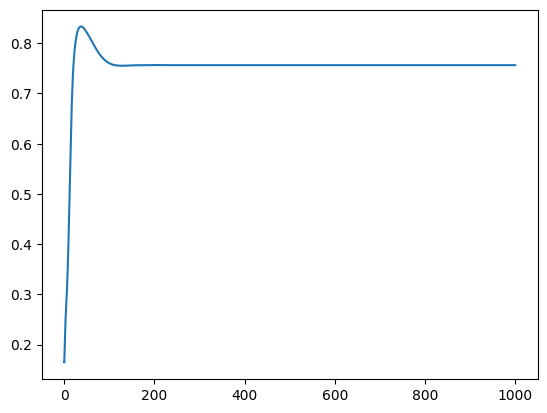

In [65]:
plt.plot(out['T'], out['N2'])

Compare to regular ivp

In [27]:
out2 = solve_ivp(full_model,
    [0,1000], y0, method = "LSODA", 
    args = (True, params_base)
)

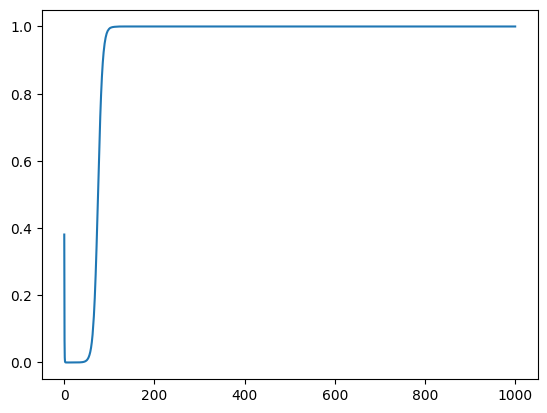

In [28]:
plt.plot(out2.t, out2.y[0])

# Test Nullclines

In [10]:
H=1
x_max = 10
params_base = dict(η1 = .2, η2 = .4, β1 = 8, β2 = 1, 
                   H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'sigmoid',
                  x_max = x_max, d = 10, A = 0.5,
                 Tx = .01, r = 0, γ = 0, pop_process = False)
N1 = 0; N2 = 0.5; 
g_of_x_vec_initial = np.zeros(params_base['x_max'])
g_of_x_vec_initial[0] = 10;

In [13]:
nullclines_prey_i_extinct([N1,N2,*g_of_x_vec_initial],
                        1,params_base.copy())

[0,
 np.float64(-3.0203389830508476),
 np.float64(-0.2390829628054887),
 np.float64(0.11954148140274436),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0)]

In [8]:
H=1
x_max = 10
params_base = dict(η1 = .2, η2 = .4, β1 = 8, β2 = 1, 
                   H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'sigmoid',
                  x_max = x_max, d = 10, A = 0.5,
                 Tx = .01, r = 0, γ = 0, pop_process = False)
N1 = 0.5; N2 = 0.5; 
g_of_x_vec_initial = np.zeros(params_base['x_max']); g_of_x_vec_initial[0] = 10;
out = group_formation_model_non_dim(1, g_of_x_vec_initial,N1,N2, params_base.copy())

In [9]:
full_model(T=1, initialstate = [1,1,*g_of_x_vec_initial], arg=1, params=params_base.copy())

[np.float64(-0.12500000000000003),
 np.float64(-2.375),
 np.float64(-9939.897242391962),
 np.float64(4969.948621195981),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0)]

In [52]:
N1_reg = 1; N2_reg = 1

In [108]:
H=2
params_pop = dict(η1 = 0.2, η2 = 0.4, A = 0.5, β1 = 10, β2 = 1, H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = 10, d = 20,
                 Tx = .1, r = 0, γ = 0, pop_process = True)
N1_reg = 1; N2_reg = 1; p_reg = 20
params = params_pop
x_max = params['x_max']
g_of_x_vec = np.array([p_reg, *np.zeros(x_max - 1)])


In [109]:
initialstate = [0.6,0.7, *g_of_x_vec]
nullclines_no_P(initialstate, params)

[np.float64(-0.12920502092050212),
 np.float64(-3.85489539748954),
 np.float64(-4015.4428257887075),
 np.float64(2007.7590697981195),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0)]

In [10]:
initialstate = [0.6,0.7, *g_of_x_vec]
t_f=5000  
out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                args=(True,params))
plt.plot(out2.y[1],out2.y[0])


NameError: name 'g_of_x_vec' is not defined

In [77]:
N1, N2 = out2.y[0:2]

In [104]:
g_of_x_vec = out2.y[2:]
x_vec = np.arange(1,11,1)
p = np.sum(x_vec*g_of_x_vec.T,1)
mean_group_size_membership(g_of_x_vec.T, x_max, p)

In [79]:
numerator[mask,:]

array([[2.00000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.99999368e+01, 1.26489906e-04, 9.01891953e-10, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.99998735e+01, 2.52978610e-04, 2.70565887e-09, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.92189508e-01, 8.46639444e-01, 4.21361461e+00, ...,
        2.41786590e-05, 5.52265317e-07, 1.10771603e-08],
       [1.90486897e-01, 8.70369392e-01, 4.34935728e+00, ...,
        2.42793046e-05, 5.40962116e-07, 1.05850315e-08],
       [1.89447501e-01, 8.79945038e-01, 4.40146916e+00, ...,
        2.40941025e-05, 5.31005384e-07, 1.02767071e-08]])

In [99]:
g_of_x_vec = out2.y[2:]

x_vec = np.arange(1,11,1)
p = np.sum(x_vec*g_of_x_vec.T,1)
g_of_x_vec = g_of_x_vec.T
mask = p > 1e-10
numerator = x_vec*(g_of_x_vec*x_vec)
numerator = numerator.sum(1)
ans = p.copy()
ans[mask] = numerator[mask]/p[mask]
ans[~mask] = np.nan

In [100]:
ans

array([1.        , 1.00000316, 1.00000632, ..., 3.37847251, 3.39481372,
       3.39994785])

In [89]:
numerator.sum(1)

array([20.        , 20.00006325, 20.00012649, ..., 14.52449726,
       15.27865848, 15.54497793])

In [86]:
ans_to_sum = p.copy()
ans_to_sum[mask,:] = numerator[mask,:].T/p[mask]
ans_to_sum[~mask,:] = np.nan

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [66]:
mask = p > 1e-10

In [67]:
mask

array([ True,  True,  True, ...,  True,  True,  True])

In [41]:
frequency_in_group_size_x = (g_of_x_vec.T*x_vec).T/p

In [43]:
vec_to_sum = x_vec*frequency_in_group_size_x.T

In [12]:
x_vec = np.arange(1,x_max+1,1)
    
    frequency_in_group_size_x = (g_of_x_vec*x_vec).T/p
    vec_to_sum = x_vec*frequency_in_group_size_x.T
    if len(vec_to_sum.shape) > 1:
        return vec_to_sum.sum(1)
    else:
        return sum(vec_to_sum)

array([], dtype=float64)

In [10]:
out2.y[1,

np.float64(0.9999937033254204)

In [214]:
P,N1,N2 = out2.y[0:3]
g_of_x_vec = out2.y[3:]

In [215]:
xvec = np.arange(1,11)